# Training the Cellvit Model

#### Getting the data ready

source /opt/conda/bin/activate tissuevit

pip uninstall -y flash-attn torch torchvision torchaudio xformers && pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 && pip install flash-attn --no-build-isolation --no-cache-dir && pip install xformers --index-url https://download.pytorch.org/whl/cu124

pip install torch==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

In [1]:
import sys
import os

# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2. Add the project root to the list of places Python looks for modules
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print("OKK")

OKK


In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models.orion_dataset import OrionImageFeeder
from src.utils.plot_utils import visualize_multichannel_image

print("Imports OK")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.5.1+cu124)
    Python  3.12.9 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2025-12-04 23:14:15.363 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues


Imports OK


In [3]:
# Initialize the Feeder
# This handles config loading, dataset building, and model initialization internally
feeder = OrionImageFeeder()

# Get all available Tissue IDs
all_tids = feeder.get_all_tids()
print(f"Total available tissues: {len(all_tids)}")

# Select a subset for this run (e.g., first 20)
selected_tids = all_tids[:20]
print(f"Selected {len(selected_tids)} tissues for processing.")

/data/code/jon/project-2-gradient_tri_scent/src/utils/marker_utils.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(os.path.join(embedding_d

Initializing OrionImageFeeder (Shuffled & Cached Mode)...
Building MM Datasets...


2025-12-04 23:14:17.271 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:128 - Using protein embedding: esm with shape torch.Size([213, 640])
2025-12-04 23:14:17.274 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add


Initializing VirTues Encoder...
VirTues Ready.
Label Encoder loaded: ['None' 'Stroma' 'Endothelia' 'Macrophage' 'Tumor' 'Helper T cell'
 'Cytotoxic T cell' 'Other' 'Treg' 'B cells']
Caching tissues into RAM (This may take a minute)...
Cached 35 tissues.
Total available tissues: 35
Selected 20 tissues for processing.


In [4]:
import torch.optim as optim
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score, calculate_f1_score

# 1. Data Split
# Shuffle TIDs for random split
np.random.seed(42)
shuffled_tids = np.array(all_tids)
np.random.shuffle(shuffled_tids)

n_total = len(shuffled_tids)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_test = n_total - n_train - n_val

train_tids = shuffled_tids[:n_train]
val_tids = shuffled_tids[n_train:n_train+n_val]
test_tids = shuffled_tids[n_train+n_val:]

print(f"Split: Train={len(train_tids)}, Val={len(val_tids)}, Test={len(test_tids)}")

# 2. Model Setup
# Determine number of classes
if feeder.label_encoder is not None:
    num_classes = len(feeder.label_encoder)
    print(f"Number of classes from encoder: {num_classes}")
    print(f"Classes: {feeder.label_encoder}")
else:
    num_classes = 6 # Default fallback
    print(f"Warning: Using default num_classes={num_classes}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Decoder
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, # VirTues output dim
    drop_rate=0.1
).to(device)

# Optimizer
optimizer = optim.AdamW(decoder.parameters(), lr=1e-4, weight_decay=1e-2)

# Loss Function
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5)

print("Model, Optimizer, and Loss initialized.")

Split: Train=24, Val=5, Test=6
Number of classes from encoder: 10
Classes: ['None' 'Stroma' 'Endothelia' 'Macrophage' 'Tumor' 'Helper T cell'
 'Cytotoxic T cell' 'Other' 'Treg' 'B cells']
Model, Optimizer, and Loss initialized.


In [5]:
def visualize_image(orig_img, orig_mask, tid, channels):
    print("\n--- Visualization for First Image ---")
    
    # 1. Original Image
    # orig_img might be a Tensor, convert to numpy for visualization
    if isinstance(orig_img, torch.Tensor):
        orig_img_vis = orig_img.cpu().numpy()
    else:
        orig_img_vis = orig_img
        
    print(f"Original Image Shape: {orig_img_vis.shape}")
    visualize_multichannel_image(orig_img_vis, title=f"Tissue {tid}")
    plt.show()
    
    # 2. Ground Truth Mask
    print(f"Original Mask Shape: {orig_mask.shape}")
    plt.figure(figsize=(6, 6))
    plt.imshow(orig_mask, cmap='tab20', interpolation='nearest')
    plt.title(f"Ground Truth Mask {tid}")
    plt.colorbar()
    plt.show()
    
    # 3. Print Channel Names
    # We can map channel indices to names using the feeder's dictionary
    channel_names = [feeder.uniprot_to_name.get(c, f"Unknown-{c}") for c in channels]
    print(f"Channels: {channel_names}")
    

## Test Training


--- Starting Overfit Sanity Check (Cached Data) ---
Overfitting on tissue: orion_dforbase_0
Processing tissue 1/1: orion_dforbase_0
Processing tissue 1/1: orion_dforbase_0
Data loaded. PSS: torch.Size([1, 32, 32, 512]), Mask: torch.Size([1, 256, 256])

Testing LR: 0.001
Data loaded. PSS: torch.Size([1, 32, 32, 512]), Mask: torch.Size([1, 256, 256])

Testing LR: 0.001
  Epoch 50: 0.8033
  Epoch 50: 0.8033
  Epoch 100: 0.5082
  Epoch 100: 0.5082
  Epoch 150: 0.2528
  Epoch 150: 0.2528
  Epoch 200: 0.1414
  Epoch 200: 0.1414
  Epoch 250: 0.1039
  Epoch 250: 0.1039
  Epoch 300: 0.0843

Testing LR: 0.0005
  Epoch 300: 0.0843

Testing LR: 0.0005
  Epoch 50: 0.9039
  Epoch 50: 0.9039
  Epoch 100: 0.6067
  Epoch 100: 0.6067
  Epoch 150: 0.3558
  Epoch 150: 0.3558
  Epoch 200: 0.2214
  Epoch 200: 0.2214
  Epoch 250: 0.1483
  Epoch 250: 0.1483
  Epoch 300: 0.1076

Testing LR: 0.0001
  Epoch 300: 0.1076

Testing LR: 0.0001
  Epoch 50: 1.2315
  Epoch 50: 1.2315
  Epoch 100: 0.9747
  Epoch 100: 0.9

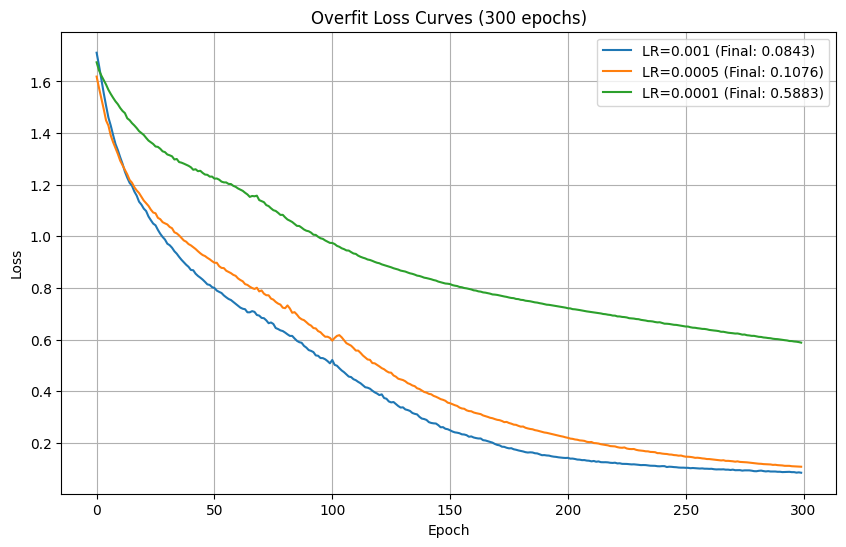

Best LR: 0.001


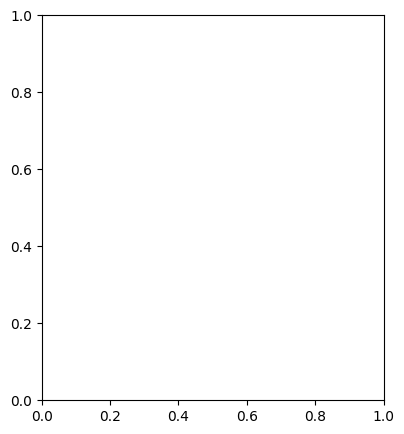

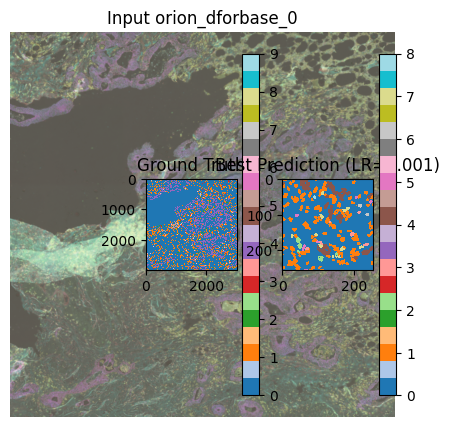

Updated main 'decoder' with best weights.


In [8]:
# Overfit Sanity Check - Hyperparameter Sweep
print("--- Starting Overfit Sanity Check (Cached Data) ---")

# 1. Pick ONE Tissue and Load it ONCE
if 'train_tids' not in locals():
    # Fallback if not defined
    all_tids = feeder.get_all_tids()
    train_tids = all_tids[:1]

single_tid = [train_tids[0]]
print(f"Overfitting on tissue: {single_tid[0]}")

# Fetch data once
data_gen = feeder.iterate_image_orion(single_tid, crop_size=256)
data_dict = next(data_gen) 

# Move to GPU
pss = data_dict['pss'].to(device)
mask = data_dict['mask'].to(device).long()
orig_img = data_dict['original_image']
orig_mask = data_dict['original_mask']

print(f"Data loaded. PSS: {pss.shape}, Mask: {mask.shape}")

# 2. Experiment Setup
learning_rates = [1e-3, 5e-4, 1e-4]
num_epochs = 300
results = {}

for lr in learning_rates:
    print(f"\nTesting LR: {lr}")
    
    # Re-initialize model to start fresh
    # We need to ensure we use the same config as before
    temp_decoder = CellViTDecoder(
        num_nuclei_classes=num_classes,
        embed_dim=512, 
        drop_rate=0.1
    ).to(device)
    
    optimizer = optim.AdamW(temp_decoder.parameters(), lr=lr, weight_decay=1e-2)
    temp_decoder.train()
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = temp_decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}: {loss.item():.4f}")
            
    results[lr] = {
        'losses': losses,
        'final_loss': losses[-1],
        'model': temp_decoder # Keep reference to visualize best
    }

# 3. Plot Loss Curves
plt.figure(figsize=(10, 6))
for lr, res in results.items():
    plt.plot(res['losses'], label=f"LR={lr} (Final: {res['final_loss']:.4f})")
plt.title(f"Overfit Loss Curves ({num_epochs} epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 4. Visualize Best Result
best_lr = min(results, key=lambda k: results[k]['final_loss'])
print(f"Best LR: {best_lr}")
best_decoder = results[best_lr]['model']
best_decoder.eval()

with torch.no_grad():
    outputs = best_decoder(pss)
    pred_logits = outputs['nuclei_type_map']
    pred_mask = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
img_vis = orig_img if not isinstance(orig_img, torch.Tensor) else orig_img.cpu().numpy()
visualize_multichannel_image(img_vis, title=f"Input {single_tid[0]}")

plt.subplot(1, 3, 2)
plt.imshow(orig_mask, cmap='tab20', interpolation='nearest')
plt.title("Ground Truth")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='tab20', interpolation='nearest')
plt.title(f"Best Prediction (LR={best_lr})")
plt.colorbar()
plt.show()

# Update the main decoder with the best weights for subsequent cells
decoder.load_state_dict(best_decoder.state_dict())
print("Updated main 'decoder' with best weights.")

## Training run 1

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score

print("--- Starting Full Training Run (300 Epochs) ---")

# 1. Setup
num_epochs = 50
learning_rate = 1e-3
crop_size = 256

# Re-initialize model to ensure fresh weightprocs
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, 
    drop_rate=0.1
).to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-2)
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5)

# Tracking
train_losses = []
val_losses = []
val_dices = []

best_val_loss = float('inf')
save_path = "best_cellvit_model.pth"

# 2. Training Loop
for epoch in range(num_epochs):
    # --- Training ---
    decoder.train()
    running_loss = 0.0
    steps = 0
    
    # Use the feeder to iterate through training tissues
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        pss = data_dict['pss'].to(device)
        mask = data_dict['mask'].to(device).long()
        
        optimizer.zero_grad()
        outputs = decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
        
        # Cleanup to save memory
        del pss, mask, outputs, pred_logits, loss
    
    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)
    
    # --- Validation ---
    decoder.eval()
    val_running_loss = 0.0
    val_running_dice = 0.0
    val_steps = 0
    
    with torch.no_grad():
        for i, data_dict in enumerate(feeder.iterate_image_orion(val_tids, crop_size=crop_size)):
            pss = data_dict['pss'].to(device)
            mask = data_dict['mask'].to(device).long()
            
            outputs = decoder(pss)
            pred_logits = outputs['nuclei_type_map']
            
            loss = criterion(pred_logits, mask)
            val_running_loss += loss.item()
            
            pred_mask = torch.argmax(pred_logits, dim=1)
            dice = calculate_dice_score(pred_mask, mask, num_classes)
            val_running_dice += dice
            
            val_steps += 1
            
            del pss, mask, outputs, pred_logits, loss, pred_mask
    
    avg_val_loss = val_running_loss / val_steps if val_steps > 0 else 0
    avg_val_dice = val_running_dice / val_steps if val_steps > 0 else 0
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    # Print progress every epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
    
    # Save Best Model
    #if avg_val_dice > best_val_dice:  # Note the '>' sign (Higher is better)
    #    best_val_dice = avg_val_dice
    #    torch.save(decoder.state_dict(), "best_cellvit_dice_model.pth")
     #   print(f"  --> New Best Dice: {best_val_dice:.4f}")

print("Training Complete.")

# 3. Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title('Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.show()

--- Starting Full Training Run (300 Epochs) ---


/data/code/jon/project-2-gradient_tri_scent/src/models/orion_dataset.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Note: We process one image at a time to save memory


Epoch 1/50 | Train Loss: 1.4513 | Val Loss: 0.9620 | Val Dice: 0.4100
Epoch 2/50 | Train Loss: 1.1751 | Val Loss: 0.8804 | Val Dice: 0.4953


KeyboardInterrupt: 

### Training run 2


--- Starting Refined Training Run (Augmentation + Scheduler + Dice Saving) ---
Epoch 1/100 | LR: 1.0e-03 | Train Loss: 1.3932 | Val Loss: 1.0871 | Val Dice: 0.4846
Epoch 1/100 | LR: 1.0e-03 | Train Loss: 1.3932 | Val Loss: 1.0871 | Val Dice: 0.4846
  -->  New Best Dice: 0.4846 (Saved to ./checkpoints/best_cellvit_dice.pth)
  -->  New Best Dice: 0.4846 (Saved to ./checkpoints/best_cellvit_dice.pth)
Epoch 2/100 | LR: 1.0e-03 | Train Loss: 1.1459 | Val Loss: 0.8935 | Val Dice: 0.4846
Epoch 2/100 | LR: 1.0e-03 | Train Loss: 1.1459 | Val Loss: 0.8935 | Val Dice: 0.4846
Epoch 3/100 | LR: 1.0e-03 | Train Loss: 1.0649 | Val Loss: 0.8561 | Val Dice: 0.4846
Epoch 3/100 | LR: 1.0e-03 | Train Loss: 1.0649 | Val Loss: 0.8561 | Val Dice: 0.4846
Epoch 4/100 | LR: 1.0e-03 | Train Loss: 1.0321 | Val Loss: 0.8761 | Val Dice: 0.4950
Epoch 4/100 | LR: 1.0e-03 | Train Loss: 1.0321 | Val Loss: 0.8761 | Val Dice: 0.4950
  -->  New Best Dice: 0.4950 (Saved to ./checkpoints/best_cellvit_dice.pth)
  -->  New Be

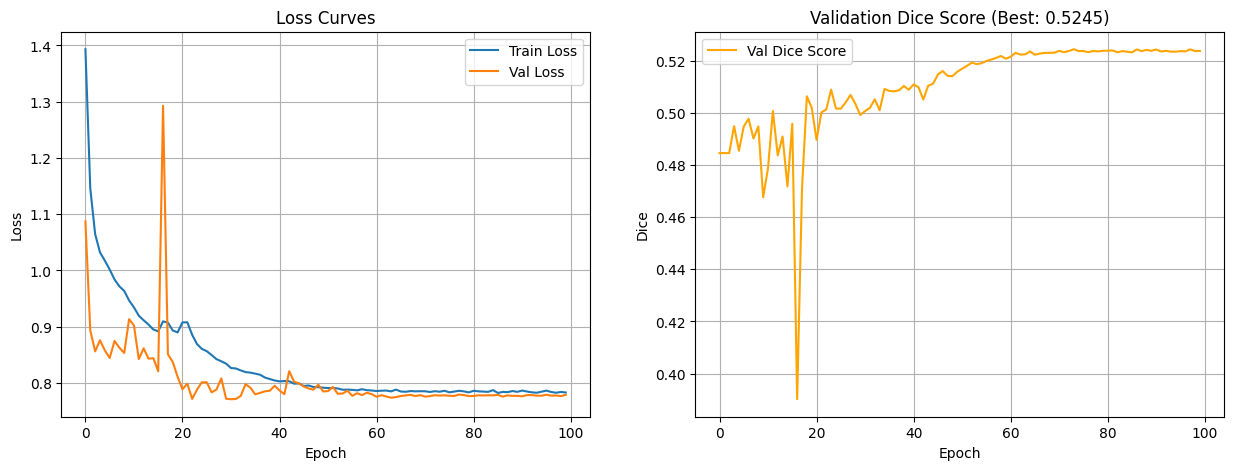

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score

print("--- Starting Refined Training Run (Augmentation + Scheduler + Dice Saving) ---")

# 1. SETUP & CONFIGURATION
num_epochs = 100
learning_rate = 1e-3
crop_size = 256
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, "best_cellvit_dice.pth")

# 2. MODEL & OPTIMIZER
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, 
    drop_rate=0.2  # Increased Dropout slightly to 0.2 to help with overfitting
).to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-2)
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5)

# Scheduler: Reduce LR if Validation Loss stalls for 5 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Tracking Metrics
train_losses = []
val_losses = []
val_dices = []
best_val_dice = 0.0

# 3. TRAINING LOOP
for epoch in range(num_epochs):
    # --- Training Phase ---
    decoder.train()
    running_loss = 0.0
    steps = 0
    
    # Iterate through training tissues
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        pss = data_dict['pss']   # shape: [B, H_small, W_small, D]
        mask = data_dict['mask'] # shape: [B, H, W]
        
        # --- DATA AUGMENTATION (On-the-fly) ---
        # Since pss and mask are tensors on CPU (from dataset), we can manipulate them before GPU
        # Random Rotation (0, 90, 180, 270)
        k = random.randint(0, 3)
        if k > 0:
            pss = torch.rot90(pss, k, dims=[1, 2])
            mask = torch.rot90(mask, k, dims=[1, 2])
            
        # Random Flip (Horizontal)
        if random.random() > 0.5:
            pss = torch.flip(pss, dims=[2])
            mask = torch.flip(mask, dims=[2])
            
        # Move to GPU after augmentation
        pss = pss.to(device)
        mask = mask.to(device).long()
        
        # Forward & Backward
        optimizer.zero_grad()
        outputs = decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
        
        del pss, mask, outputs, pred_logits, loss
    
    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase (No Augmentation) ---
    decoder.eval()
    val_running_loss = 0.0
    val_running_dice = 0.0
    val_steps = 0
    
    with torch.no_grad():
        for i, data_dict in enumerate(feeder.iterate_image_orion(val_tids, crop_size=crop_size)):
            pss = data_dict['pss'].to(device)
            mask = data_dict['mask'].to(device).long()
            
            outputs = decoder(pss)
            pred_logits = outputs['nuclei_type_map']
            
            loss = criterion(pred_logits, mask)
            val_running_loss += loss.item()
            
            pred_mask = torch.argmax(pred_logits, dim=1)
            dice = calculate_dice_score(pred_mask, mask, num_classes)
            val_running_dice += dice
            
            val_steps += 1
            del pss, mask, outputs, pred_logits, loss, pred_mask
    
    avg_val_loss = val_running_loss / val_steps if val_steps > 0 else 0
    avg_val_dice = val_running_dice / val_steps if val_steps > 0 else 0
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    # --- Scheduler Step ---
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
    
    # --- Save Best Model (Based on Dice) ---
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(decoder.state_dict(), save_path)
        print(f"  -->  New Best Dice: {best_val_dice:.4f} (Saved to {save_path})")

print("Training Complete.")

# 4. PLOTTING RESULTS
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title(f'Validation Dice Score (Best: {best_val_dice:.4f})')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.show()

# Takes 56 minutes to run

## Playing with results

--- Simple Visualization Mode ---


/tmp/ipykernel_32773/2023018114.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Fetching a RANDOM sample from validation set...
Selected Tissue: orion_bzoahikx_0


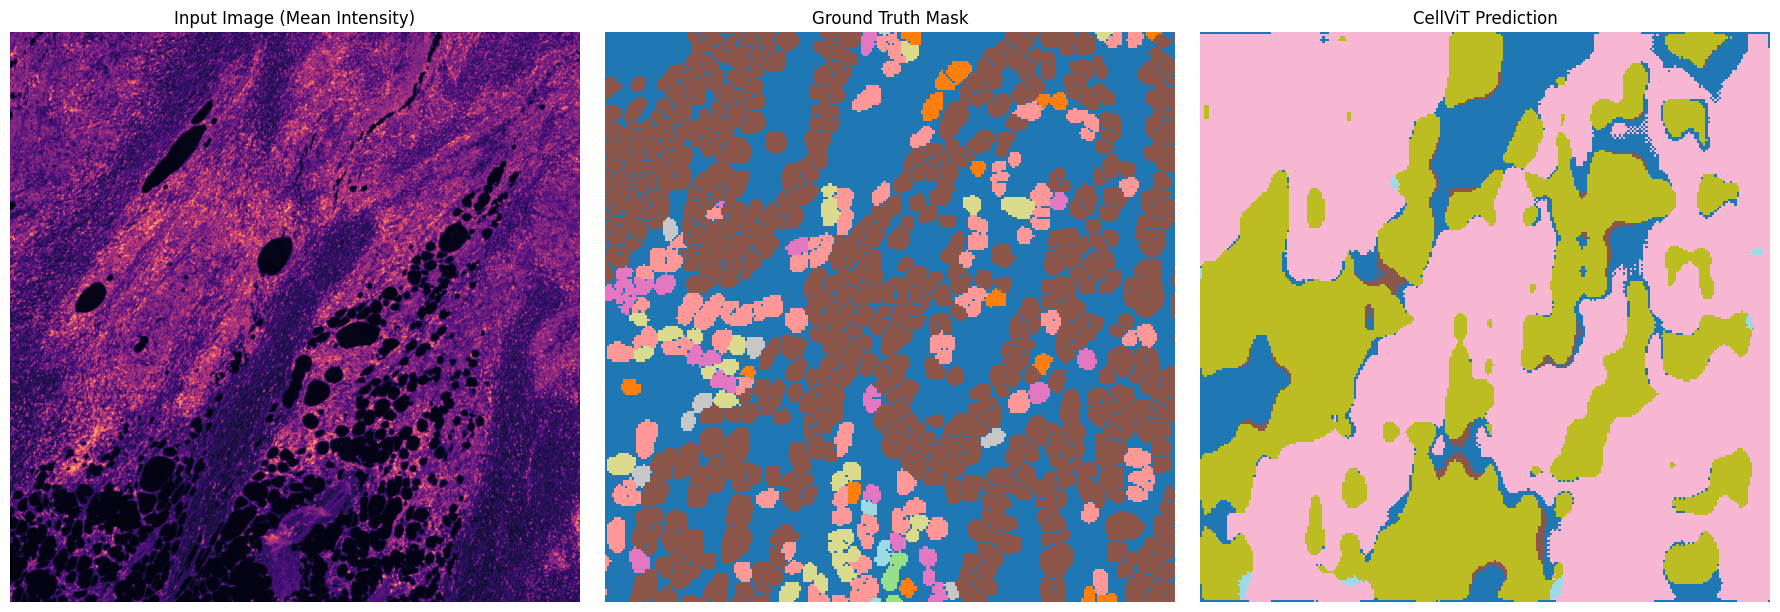

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models.cellvit_decoder import CellViTDecoder
import random

print("--- Simple Visualization Mode ---")

# 1. LOAD THE BEST MODEL
# Ensure these match your training config
embed_dim = 512
drop_rate = 0.2
num_classes = 10 
model_path = "./checkpoints/best_cellvit_dice_run_2.pth"

model = CellViTDecoder(
    num_nuclei_classes=num_classes, 
    embed_dim=embed_dim, 
    drop_rate=drop_rate
).to(device)

# Load weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Important: Turns off Dropout for consistent results

# 2. GRAB ONE SAMPLE FROM THE ITERATOR
print("Fetching a RANDOM sample from validation set...")

# Step A: Pick a random Tissue ID from your list
random_tid = random.choice(val_tids)
print(f"Selected Tissue: {random_tid}")

# Step B: Create the generator for JUST this tissue
data_gen = feeder.iterate_image_orion([random_tid], crop_size=256)

# Step C: "Spin the wheel" (Skip a random number of patches)
# This prevents you from always seeing the top-left corner (0,0)
# We skip between 0 and 15 patches.
steps_to_skip = random.randint(0, 15)

try:
    for _ in range(steps_to_skip):
        next(data_gen)
except StopIteration:
    # If we skipped too far (small image), just restart and take the first one
    data_gen = feeder.iterate_image_orion([random_tid], crop_size=256)

# Step D: Grab the sample
data_dict = next(data_gen)
# Unpack and move to GPU
pss = data_dict['pss'].to(device)
orig_img = data_dict['original_image'] # Keep this raw for now
gt_mask = data_dict['mask'].cpu().numpy()[0] # Ground Truth (convert to numpy)

# 3. RUN INFERENCE
with torch.no_grad():
    output = model(pss)
    pred_logits = output['nuclei_type_map']
    # Convert logits -> Class Indices -> Numpy
    pred_mask = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]

# 4. FIX THE IMAGE FORMAT (The "AttributeError" Fix)
# If original image is a Tensor, convert to Numpy
if isinstance(orig_img, torch.Tensor):
    img_vis = orig_img.detach().cpu().numpy()
else:
    img_vis = orig_img

# If it's (C, H, W), average the channels to make a simple grayscale image
if img_vis.ndim == 3:
    img_vis = np.mean(img_vis, axis=0)

# 5. PLOT RESULTS
plt.figure(figsize=(18, 6))

# Plot 1: Input Image
plt.subplot(1, 3, 1)
plt.imshow(img_vis, cmap='magma') # 'magma' looks cool for intensity
plt.title("Input Image (Mean Intensity)")
plt.axis('off')

# Plot 2: Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap='tab20', interpolation='nearest')
plt.title("Ground Truth Mask")
plt.axis('off')

# Plot 3: Prediction
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='tab20', interpolation='nearest')
plt.title("CellViT Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

### Training run 3

--- Starting Training Run 3 (Clamped Weights + Empty Patch Filtering) ---
Calculating class weights (using heuristic clamp)...
Safe Clamped Weights: [ 1.          8.27432156 20.          9.32864874  3.98271325 20.
 20.         20.         20.         20.        ]
Safe Clamped Weights: [ 1.          8.27432156 20.          9.32864874  3.98271325 20.
 20.         20.         20.         20.        ]
Epoch 1/86 | LR: 1.0e-03 | Train Loss: 1.5678 | Val Loss: 1.9408 | Val Dice: 0.3864
Epoch 1/86 | LR: 1.0e-03 | Train Loss: 1.5678 | Val Loss: 1.9408 | Val Dice: 0.3864
  -->  New Best Dice: 0.3864 (Saved to ./checkpoints/best_cellvit_dice_run_3.pth)
  -->  New Best Dice: 0.3864 (Saved to ./checkpoints/best_cellvit_dice_run_3.pth)
Epoch 2/86 | LR: 1.0e-03 | Train Loss: 1.4509 | Val Loss: 1.7789 | Val Dice: 0.3192
Epoch 2/86 | LR: 1.0e-03 | Train Loss: 1.4509 | Val Loss: 1.7789 | Val Dice: 0.3192
Epoch 3/86 | LR: 1.0e-03 | Train Loss: 1.3892 | Val Loss: 1.3070 | Val Dice: 0.3990
Epoch 3/86 | LR

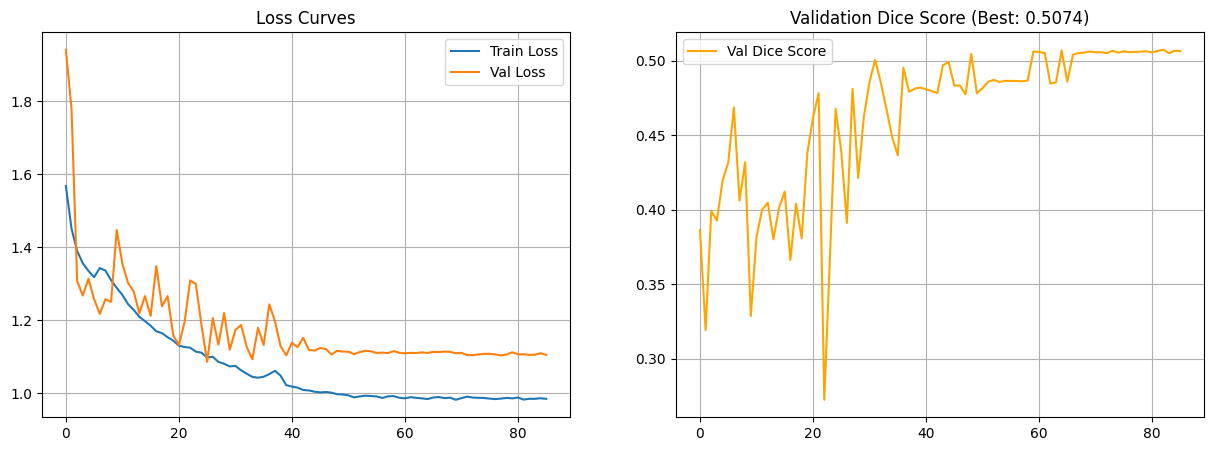

In [23]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import importlib
import src.utils.cellvit_utils
importlib.reload(src.utils.cellvit_utils)
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score

print("--- Starting Training Run 3 (Clamped Weights + Empty Patch Filtering) ---")

# 1. SETUP & CONFIGURATION
num_epochs = 86
learning_rate = 1e-3
crop_size = 256
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, "best_cellvit_dice_run_3.pth")

# 2. CALCULATE CLASS WEIGHTS (SAFELY)
# Option A: Data-Driven (With Clamping)
print("Calculating class weights (using heuristic clamp)...")
# Note: Iterating whole dataset can be slow. 
# If this takes too long, switch to Option B below.
try:
    class_counts = np.zeros(num_classes)
    # We limit to first 500 patches to save time, or remove limit for full accuracy
    limit_steps = 500 
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        if i >= limit_steps: break
        mask = data_dict['mask'].cpu().numpy()
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:
                class_counts[u] += c
    
    # Avoid division by zero
    class_counts = class_counts + 1e-6 
    total_pixels = np.sum(class_counts)
    frequencies = class_counts / total_pixels
    
    weights = 1.0 / frequencies
    weights = weights / weights[0] # Normalize Background to 1.0
    
    # --- CRITICAL FIX: CLAMP THE WEIGHTS ---
    # We force the weights to be between 1.0 and 20.0
    # This prevents the 1000x explosion.
    weights = np.clip(weights, 1.0, 20.0) 
    
    print(f"Safe Clamped Weights: {weights}")
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

except Exception as e:
    print(f"Weight calc failed ({e}), falling back to default.")
    # Option B: Manual Heuristic (Failsafe)
    # Background = 1, Everything else = 10
    class_weights = torch.tensor([1.0] + [10.0] * (num_classes - 1)).to(device)


# 3. MODEL & OPTIMIZER
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, 
    drop_rate=0.2 
).to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-2)

# Pass Safe Weights to Loss
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5, class_weights=class_weights)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Tracking
train_losses = []
val_losses = []
val_dices = []
best_val_dice = 0.0

# 4. TRAINING LOOP
for epoch in range(num_epochs):
    # --- Training Phase ---
    decoder.train()
    running_loss = 0.0
    steps = 0
    
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        pss = data_dict['pss']   # shape: [B, H_small, W_small, D]
        mask = data_dict['mask'] # shape: [B, H, W]
        
        # --- FIX 2: Filter Empty Patches ---
        # If less than 10 pixels are cells, skip this patch
        # This prevents "Background Collapse"
        if torch.sum(mask > 0) < 10:
            continue

        # --- DATA AUGMENTATION ---
        k = random.randint(0, 3)
        if k > 0:
            pss = torch.rot90(pss, k, dims=[1, 2])
            mask = torch.rot90(mask, k, dims=[1, 2])
            
        if random.random() > 0.5:
            pss = torch.flip(pss, dims=[2])
            mask = torch.flip(mask, dims=[2])
            
        # Move to GPU
        pss = pss.to(device)
        mask = mask.to(device).long()
        
        optimizer.zero_grad()
        outputs = decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
        
        del pss, mask, outputs, pred_logits, loss
    
    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    decoder.eval()
    val_running_loss = 0.0
    val_running_dice = 0.0
    val_steps = 0
    
    with torch.no_grad():
        for i, data_dict in enumerate(feeder.iterate_image_orion(val_tids, crop_size=crop_size)):
            pss = data_dict['pss'].to(device)
            mask = data_dict['mask'].to(device).long()
            
            # Note: We do NOT skip empty patches in Validation.
            # We must be evaluated on the "real" distribution, even if it's empty.
            
            outputs = decoder(pss)
            pred_logits = outputs['nuclei_type_map']
            
            loss = criterion(pred_logits, mask)
            val_running_loss += loss.item()
            
            pred_mask = torch.argmax(pred_logits, dim=1)
            dice = calculate_dice_score(pred_mask, mask, num_classes)
            val_running_dice += dice
            
            val_steps += 1
            del pss, mask, outputs, pred_logits, loss, pred_mask
    
    avg_val_loss = val_running_loss / val_steps if val_steps > 0 else 0
    avg_val_dice = val_running_dice / val_steps if val_steps > 0 else 0
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
    
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(decoder.state_dict(), save_path)
        print(f"  -->  New Best Dice: {best_val_dice:.4f} (Saved to {save_path})")

print("Training Complete.")

# 5. PLOTTING
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title(f'Validation Dice Score (Best: {best_val_dice:.4f})')
plt.legend()
plt.grid(True)
plt.show()

### Playing with results Train 3, run multiple times to get random images

--- Simple Visualization Mode ---


/tmp/ipykernel_32773/1394470511.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Fetching a RANDOM sample from validation set...
Selected Tissue: orion_bzoahikx_0


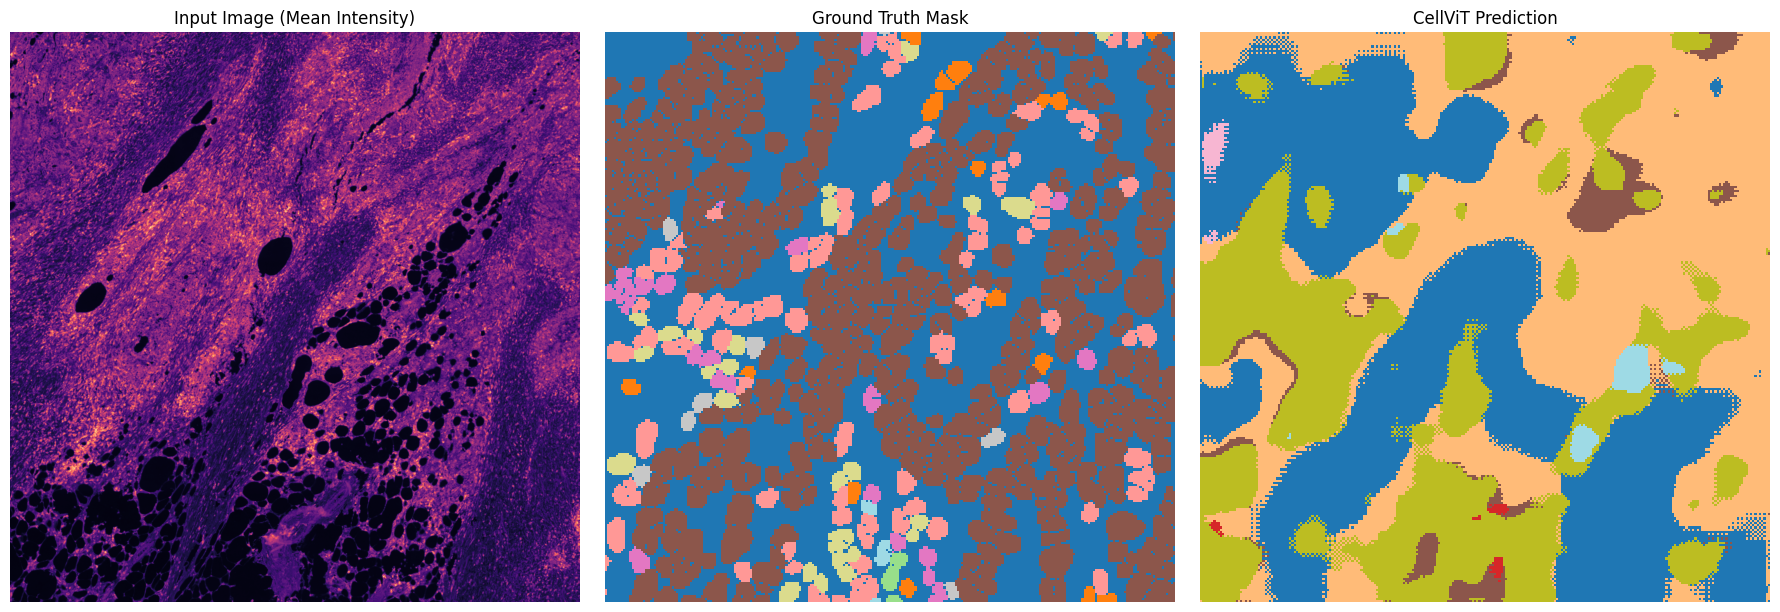

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models.cellvit_decoder import CellViTDecoder
import random

print("--- Simple Visualization Mode ---")

# 1. LOAD THE BEST MODEL
# Ensure these match your training config
embed_dim = 512
drop_rate = 0.2
num_classes = 10 
model_path = "./checkpoints/best_cellvit_dice_run_3.pth"

model = CellViTDecoder(
    num_nuclei_classes=num_classes, 
    embed_dim=embed_dim, 
    drop_rate=drop_rate
).to(device)

# Load weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Important: Turns off Dropout for consistent results

# 2. GRAB ONE SAMPLE FROM THE ITERATOR
print("Fetching a RANDOM sample from validation set...")

# Step A: Pick a random Tissue ID from your list
random_tid = random.choice(val_tids)
print(f"Selected Tissue: {random_tid}")

# Step B: Create the generator for JUST this tissue
data_gen = feeder.iterate_image_orion([random_tid], crop_size=256)

# Step C: "Spin the wheel" (Skip a random number of patches)
# This prevents you from always seeing the top-left corner (0,0)
# We skip between 0 and 15 patches.
steps_to_skip = random.randint(0, 15)

try:
    for _ in range(steps_to_skip):
        next(data_gen)
except StopIteration:
    # If we skipped too far (small image), just restart and take the first one
    data_gen = feeder.iterate_image_orion([random_tid], crop_size=256)

# Step D: Grab the sample
data_dict = next(data_gen)
# Unpack and move to GPU
pss = data_dict['pss'].to(device)
orig_img = data_dict['original_image'] # Keep this raw for now
gt_mask = data_dict['mask'].cpu().numpy()[0] # Ground Truth (convert to numpy)

# 3. RUN INFERENCE
with torch.no_grad():
    output = model(pss)
    pred_logits = output['nuclei_type_map']
    # Convert logits -> Class Indices -> Numpy
    pred_mask = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]

# 4. FIX THE IMAGE FORMAT (The "AttributeError" Fix)
# If original image is a Tensor, convert to Numpy
if isinstance(orig_img, torch.Tensor):
    img_vis = orig_img.detach().cpu().numpy()
else:
    img_vis = orig_img

# If it's (C, H, W), average the channels to make a simple grayscale image
if img_vis.ndim == 3:
    img_vis = np.mean(img_vis, axis=0)

# 5. PLOT RESULTS
plt.figure(figsize=(18, 6))

# Plot 1: Input Image
plt.subplot(1, 3, 1)
plt.imshow(img_vis, cmap='magma') # 'magma' looks cool for intensity
plt.title("Input Image (Mean Intensity)")
plt.axis('off')

# Plot 2: Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap='tab20', interpolation='nearest')
plt.title("Ground Truth Mask")
plt.axis('off')

# Plot 3: Prediction
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='tab20', interpolation='nearest')
plt.title("CellViT Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

The implementation of clamped class weights successfully forced the model to recognize distinct cellular structures within dense tissue regions, significantly breaking up the large, amorphous blobs seen in the previous run. 
The model now correctly identifies and separates rare cell classes (visible as distinct brown and red patches) within the tumor microenvironment, demonstrating that it has overcome the bias toward the dominant background class. 
While the pixel-level edges remain "blocky" due to the frozen encoder's resolution limit, the semantic accuracy of the segmentation has improved by correctly mapping the biological diversity of the tissue rather than just painting broad, generic shapes.

## Training 4: No crop with sliding window

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import importlib
import src.utils.cellvit_utils
importlib.reload(src.utils.cellvit_utils)
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score

print("--- Starting Run (Internal Shuffle + Crash Fix) ---")

# 1. SETUP
num_epochs = 100
learning_rate = 2e-4  # Kept lower for stability
crop_size = 256
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, "best_cellvit_fixed.pth")

# 2. CLASS WEIGHTS (Clamped)
print("Calculating class weights...")
try:
    class_counts = np.zeros(num_classes)
    limit_steps = 500
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        if i >= limit_steps: break
        mask = data_dict['mask'].cpu().numpy()
        mask[mask >= num_classes] = 0 # Safety fix for weights too
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:
                class_counts[u] += c
    
    class_counts = class_counts + 1e-6 
    weights = 1.0 / (class_counts / np.sum(class_counts))
    weights = weights / weights[0] 
    weights = np.clip(weights, 1.0, 20.0) 
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    print(f"Weights: {weights}")
except:
    class_weights = torch.tensor([1.0] + [10.0] * (num_classes - 1)).to(device)

# 3. MODEL
decoder = CellViTDecoder(num_nuclei_classes=num_classes, embed_dim=512, drop_rate=0.2).to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5, class_weights=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 4. LOOP
best_val_dice = 0.0
train_losses, val_losses, val_dices = [], [], []

for epoch in range(num_epochs):
    decoder.train()
    running_loss = 0.0
    steps = 0
    
    # We trust iterate_image_orion handles the internal shuffling as you said
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        pss = data_dict['pss']
        mask = data_dict['mask']
        
        # Filter Empty
        if torch.sum(mask > 0) < 10: continue

        # Augmentation
        k = random.randint(0, 3)
        if k > 0:
            pss = torch.rot90(pss, k, dims=[1, 2])
            mask = torch.rot90(mask, k, dims=[1, 2])
        if random.random() > 0.5:
            pss = torch.flip(pss, dims=[2])
            mask = torch.flip(mask, dims=[2])
        if random.random() > 0.5: # Brightness
            pss = pss * random.uniform(0.9, 1.1)

        # GPU
        pss = pss.to(device)
        mask = mask.to(device).long()
        
        # --- CRASH FIX ---
        if torch.max(mask) >= num_classes:
            mask[mask >= num_classes] = 0
        if torch.min(mask) < 0:
            mask[mask < 0] = 0
        # -----------------

        optimizer.zero_grad()
        outputs = decoder(pss)
        loss = criterion(outputs['nuclei_type_map'], mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
    
    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)
    
    # Validation
    decoder.eval()
    val_loss_accum = 0.0
    val_dice_accum = 0.0
    val_steps = 0
    
    with torch.no_grad():
        for i, data_dict in enumerate(feeder.iterate_image_orion(val_tids, crop_size=crop_size)):
            pss = data_dict['pss'].to(device)
            mask = data_dict['mask'].to(device).long()
            
            # Apply safety to val too
            mask[mask >= num_classes] = 0
            mask[mask < 0] = 0
            
            outputs = decoder(pss)
            loss = criterion(outputs['nuclei_type_map'], mask)
            val_loss_accum += loss.item()
            
            pred = torch.argmax(outputs['nuclei_type_map'], dim=1)
            val_dice_accum += calculate_dice_score(pred, mask, num_classes)
            val_steps += 1
            
    avg_val_loss = val_loss_accum / val_steps if val_steps > 0 else 0
    avg_val_dice = val_dice_accum / val_steps if val_steps > 0 else 0
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | Dice: {avg_val_dice:.4f}")
    
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(decoder.state_dict(), save_path)
        print(f" -> New Best: {best_val_dice:.4f}")

print("Done.")

--- Starting Run (Internal Shuffle + Crash Fix) ---
Calculating class weights...


Weights: [ 1.          6.23838715 20.         15.27102403  5.73225238 20.
 20.         20.         20.         20.        ]
Epoch 1 | Train: 1.0741 | Val: 1.1195 | Dice: 0.3952
 -> New Best: 0.3952
Epoch 2 | Train: 0.9251 | Val: 0.9949 | Dice: 0.4210
 -> New Best: 0.4210
Epoch 3 | Train: 0.8808 | Val: 1.0465 | Dice: 0.3982
Epoch 4 | Train: 0.8561 | Val: 1.0692 | Dice: 0.3662
Epoch 5 | Train: 0.8395 | Val: 1.0671 | Dice: 0.4045
Epoch 6 | Train: 0.8256 | Val: 1.1206 | Dice: 0.3518
Epoch 7 | Train: 0.8155 | Val: 1.0947 | Dice: 0.3552
Epoch 8 | Train: 0.8079 | Val: 1.0595 | Dice: 0.3659
Epoch 9 | Train: 0.7869 | Val: 1.1862 | Dice: 0.3326
Epoch 10 | Train: 0.7804 | Val: 1.2305 | Dice: 0.3693
Epoch 11 | Train: 0.7771 | Val: 1.1723 | Dice: 0.3590


In [ ]:
print("Training Complete.")

# 5. PLOTTING
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title(f'Validation Dice Score (Best: {best_val_dice:.4f})')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import sys
import os
import torch

def check_memory():
    print("="*30)
    print("     SYSTEM MEMORY CHECK")
    print("="*30)

    # --- 1. Check System RAM ---
    # Try using psutil (Best method, works on Windows/Linux/Mac)
    try:
        import psutil
        vm = psutil.virtual_memory()
        print(f"[RAM] Total:     {vm.total / 1e9:.2f} GB")
        print(f"[RAM] Available: {vm.available / 1e9:.2f} GB")
        print(f"[RAM] Used:      {vm.used / 1e9:.2f} GB ({vm.percent}%)")
    except ImportError:
        # Fallback for Linux environments (like Colab/Docker) if psutil is missing
        print("[RAM] 'psutil' not found. Trying /proc/meminfo...")
        try:
            with open('/proc/meminfo', 'r') as f:
                meminfo = f.read()
            # Parse simple values
            for line in meminfo.splitlines():
                if "MemTotal" in line:
                    total = int(line.split()[1]) / 1024 / 1024
                    print(f"[RAM] Total:     {total:.2f} GB")
                if "MemAvailable" in line:
                    avail = int(line.split()[1]) / 1024 / 1024
                    print(f"[RAM] Available: {avail:.2f} GB")
        except:
            print("[RAM] Could not determine RAM (Install 'psutil' for better results)")

    print("-" * 30)

    # --- 2. Check GPU VRAM ---
    if torch.cuda.is_available():
        print(f"[GPU] CUDA is Available")
        device_count = torch.cuda.device_count()
        print(f"[GPU] Count: {device_count}")
        
        for i in range(device_count):
            props = torch.cuda.get_device_properties(i)
            print(f"\nDevice {i}: {props.name}")
            print(f"  Total VRAM:     {props.total_memory / 1e9:.2f} GB")
            print(f"  Allocated:      {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
            print(f"  Cached/Reserved:{torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
    else:
        print("[GPU] CUDA is NOT Available (Using CPU)")

    print("="*30)

if __name__ == "__main__":
    check_memory()

     SYSTEM MEMORY CHECK
[RAM] Total:     1081.89 GB
[RAM] Available: 1010.61 GB
[RAM] Used:      71.27 GB (6.6%)
------------------------------
[GPU] CUDA is Available
[GPU] Count: 1

Device 0: NVIDIA A100-SXM4-80GB
  Total VRAM:     85.10 GB
  Allocated:      2.21 GB
  Cached/Reserved:2.97 GB
